# Demo: Image Classification, Attributes, and Retrieval

This notebook demos:
- Predicting class and attributes for an image
- Text-to-image retrieval (top-k)
- Image-to-image retrieval (top-k)

It reuses utilities from `Milestone2_Image_Understanding_Pipeline.py`.


In [1]:
# Setup
import os
import sys
from pathlib import Path

# Ensure we can import the pipeline module
proj_root = Path('/Users/jayantkapoor/Desktop/DL_Milestone_2')
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Import pipeline utilities
import Milestone2_Image_Understanding_Pipeline as M2

# Config — update these if your data/checkpoints are elsewhere
MODEL_KEY = 'vits'  # one of: 'vits', 'swint'
DATA_ROOT = 'data'
LABELS_CSV = 'data/labels.csv'
CLASSES_TXT = 'data/classes.txt'
ATTRS_YAML = 'data/attributes.yaml'
OUT_DIR = 'outputs'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

cfg = M2.TrainConfig(
    model_name=M2.MODELS[MODEL_KEY],
    data_root=DATA_ROOT,
    labels_csv=LABELS_CSV,
    classes_txt=CLASSES_TXT,
    attributes_yaml=ATTRS_YAML,
    out_dir=OUT_DIR,
    device=DEVICE,
)

print('Device:', cfg.device)
run_dir = os.path.join(cfg.out_dir, os.path.basename(cfg.model_name))
print('Run dir:', run_dir)



/Users/jayantkapoor/Desktop/DL_Milestone_2/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu
Run dir: outputs/vit_small_patch16_224


In [ ]:
# Helpers for prediction and visualization
from typing import List, Dict, Any

def load_model_and_vocab(cfg: M2.TrainConfig):
    device = torch.device(cfg.device)
    vocab = M2.Vocab.from_files(cfg.classes_txt, cfg.attributes_yaml)
    run_dir = os.path.join(cfg.out_dir, os.path.basename(cfg.model_name))
    best_path = os.path.join(run_dir, 'best.pt')
    if not os.path.exists(best_path):
        raise FileNotFoundError(f'Missing checkpoint: {best_path}. Please train or copy a checkpoint first.')
    state = torch.load(best_path, map_location='cpu')
    model = M2.MultiTaskNet(cfg.model_name, vocab).to(device).eval()
    model.load_state_dict(state['model'])
    return model, vocab

@torch.no_grad()
def predict_image(cfg: M2.TrainConfig, image_path: str, topk: int = 5, res: int = 224) -> Dict[str, Any]:
    model, vocab = load_model_and_vocab(cfg)
    device = torch.device(cfg.device)
    _, tfm = M2.make_transforms(res)

    full = image_path if os.path.isabs(image_path) else os.path.join(cfg.data_root, image_path)
    if not os.path.exists(full):
        raise FileNotFoundError(f'Not found: {full}')

    with Image.open(full) as im:
        im = im.convert('RGB')
        x = tfm(im).unsqueeze(0).to(device)

    out = model(x)
    cls_probs = torch.softmax(out['class'], dim=1)[0].cpu().numpy()
    cls_topk_idx = np.argsort(-cls_probs)[:topk]
    cls_topk = [{
        'label': vocab.classes[i],
        'prob': float(cls_probs[i])
    } for i in cls_topk_idx]

    def head_pred(head: str, labels: List[str]):
        logits = out[head][0]
        probs = torch.softmax(logits, dim=0).cpu().numpy()
        idx = int(np.argmax(probs))
        return {
            'label': labels[idx],
            'prob': float(probs[idx]),
            'top3': [{'label': labels[i], 'prob': float(probs[i])} for i in np.argsort(-probs)[:3]]
        }

    pred = {
        'image': full,
        'class': {
            'top1': cls_topk[0]['label'],
            'top1_prob': float(cls_topk[0]['prob']),
            'topk': cls_topk,
            'humanized': M2.humanize_label(cls_topk[0]['label']),
        },
        'attributes': {
            'color': head_pred('color', vocab.colors),
            'material': head_pred('material', vocab.materials),
            'condition': head_pred('condition', vocab.conditions),
            'size': head_pred('size', vocab.sizes),
            # 'features': head_pred('features', vocab.features), #Comment the line if Our Dataset
            # 'pattern': head_pred('pattern', vocab.patterns), #Comment the line if Our Dataset
            # 'shape': head_pred('shape', vocab.shapes), #Comment the line if Our Dataset
            # 'style': head_pred('style', vocab.styles), #Comment the line if Our Dataset
        }
    }
    return pred


def show_image(path: str, title: str = ''):
    with Image.open(path) as im:
        plt.imshow(im.convert('RGB'))
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


## Predict class and attributes for an image


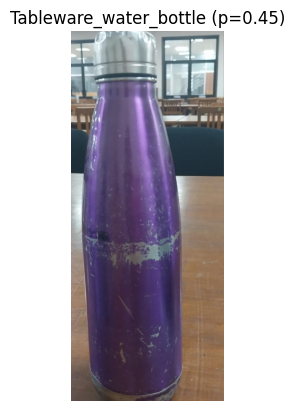

Class top-k:
  1. Tableware_water_bottle (p=0.455)
  2. Travel_backpack (p=0.138)
  3. cosmetics_nailpolish (p=0.116)
  4. personal_care_toothbrush (p=0.097)
  5. food_storage_plastic_container (p=0.059)

Attributes:
- color: purple (p=0.357) | top3: purple(0.36), silver(0.10), gray(0.10)
- material: plastic (p=0.687) | top3: plastic(0.69), ceramic(0.16), metal(0.06)
- condition: used (p=0.989) | top3: used(0.99), new(0.01), unknown(0.00)
- size: small (p=0.551) | top3: small(0.55), medium(0.26), large(0.15)


In [8]:
# Choose an image (relative to DATA_ROOT or absolute)
example_image = '/Users/jayantkapoor/Downloads/WhatsApp Image 2025-10-27 at 19.18.57.jpeg'  # change to an image that exists in your dataset
TOPK = 5

try:
    pred = predict_image(cfg, example_image, topk=TOPK)
    show_image(pred['image'], title=f"{pred['class']['top1']} (p={pred['class']['top1_prob']:.2f})")

    print('Class top-k:')
    for i, item in enumerate(pred['class']['topk'], 1):
        print(f"  {i}. {item['label']} (p={item['prob']:.3f})")

    print('\nAttributes:')
    for k, a in pred['attributes'].items():
        top3 = ', '.join([f"{t['label']}({t['prob']:.2f})" for t in a['top3']])
        print(f"- {k}: {a['label']} (p={a['prob']:.3f}) | top3: {top3}")
except FileNotFoundError as e:
    print(str(e))
    print('Please set example_image to a valid path.')


## Text-to-image retrieval (top-k)


In [6]:
# Build gallery features once, then run arbitrary text queries
from tqdm.auto import tqdm

def load_retrieval_artifacts(cfg: M2.TrainConfig):
    device = torch.device(cfg.device)
    model, vocab = load_model_and_vocab(cfg)
    run_dir = os.path.join(cfg.out_dir, os.path.basename(cfg.model_name))
    rpath = os.path.join(run_dir, 'retrieval.pt')
    if not os.path.exists(rpath):
        raise FileNotFoundError(f'Missing retrieval head at {rpath}. Run the training cell below to create it.')
    rstate = torch.load(rpath, map_location='cpu')

    txt = M2.TextEncoder().to(device).eval()
    txt.load_state_dict(rstate['text_encoder'])
    head = M2.RetrievalHead(model.backbone.num_features, txt.dim, 256).to(device).eval()
    head.load_state_dict(rstate['retrieval_head'])
    return model, txt, head, vocab

@torch.no_grad()
def build_gallery(cfg: M2.TrainConfig):
    device = torch.device(cfg.device)
    model, txt, head, vocab = load_retrieval_artifacts(cfg)
    df = np.array([])
    import pandas as pd
    df = pd.read_csv(cfg.labels_csv)
    df.columns = [str(c).strip().lower() for c in df.columns]

    _, tfm = M2.make_transforms(224)
    img_paths = df['path'].tolist()
    full_paths = [p if os.path.isabs(p) else os.path.join(cfg.data_root, p) for p in img_paths]

    feats = []
    for p in tqdm(full_paths, desc='encode-gallery', leave=False):
        with Image.open(p) as im:
            x = tfm(im.convert('RGB')).unsqueeze(0).to(device)
        feats.append(model.extract_features(x))
    gfeats = torch.cat(feats, dim=0)
    return full_paths, gfeats, model, txt, head, vocab

@torch.no_grad()
def retrieve_text(query: str, full_paths, gfeats, txt: M2.TextEncoder, head: M2.RetrievalHead, topk: int = 5):
    device = next(gfeats.parameters(), torch.tensor(0)).device if hasattr(gfeats, 'parameters') else gfeats.device
    qz = txt.encode([query], str(device))
    zi, zt, _ = head(gfeats, qz)
    scores = (zi @ zt.t()).squeeze(1).cpu().numpy()
    top_idx = np.argsort(-scores)[:topk]
    return [(full_paths[i], float(scores[i])) for i in top_idx]


def show_topk(paths_and_scores):
    k = len(paths_and_scores)
    fig, axes = plt.subplots(1, k, figsize=(2.4*k, 2.6))
    if k == 1:
        axes = [axes]
    for ax, (p, s) in zip(axes, paths_and_scores):
        ax.axis('off')
        with Image.open(p) as im:
            ax.imshow(im.convert('RGB'))
        ax.set_title(f"{Path(p).name}\nscore={s:.3f}", fontsize=8)
    plt.tight_layout()
    plt.show()

# Build gallery (takes time on first run)
try:
    gallery_paths, gallery_feats, model_r, txt_r, head_r, vocab_r = build_gallery(cfg)
    print(f'Gallery encoded: {len(gallery_paths)} images')
except FileNotFoundError as e:
    print(str(e))
    print('Skip until retrieval artifacts are trained/saved.')

# Example query
# query = 'black metal bucket'  # change to your phrase
# topk_results = retrieve_text(query, gallery_paths, gallery_feats, txt_r, head_r, topk=5)
# show_topk(topk_results)



Gallery encoded: 607 images


## Image-to-image retrieval (top-k)


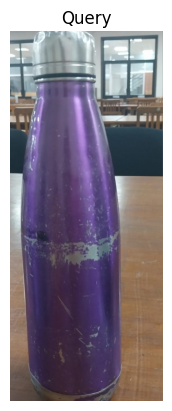

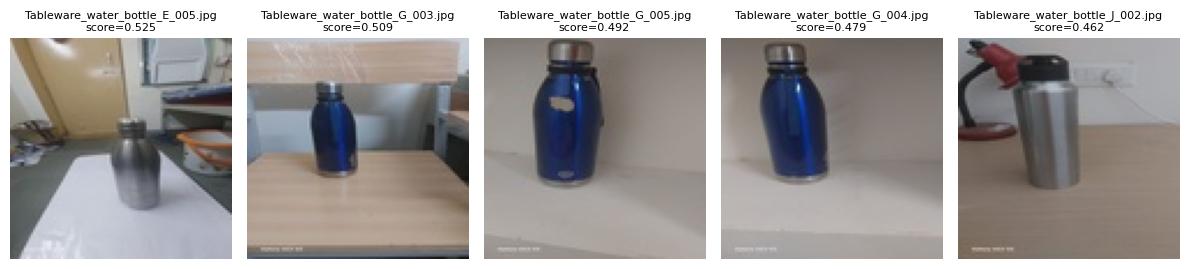

In [7]:
@torch.no_grad()
def retrieve_image(query_image: str, gallery_paths, gallery_feats, model: M2.MultiTaskNet, topk: int = 5):
    device = torch.device(cfg.device)
    _, tfm = M2.make_transforms(224)

    qfull = query_image if os.path.isabs(query_image) else os.path.join(cfg.data_root, query_image)
    if not os.path.exists(qfull):
        raise FileNotFoundError(f'Not found: {qfull}')

    with Image.open(qfull) as im:
        x = tfm(im.convert('RGB')).unsqueeze(0).to(device)
    qf = model.extract_features(x)  # [1, d]

    # cosine similarity
    qn = torch.nn.functional.normalize(qf, dim=-1)
    gn = torch.nn.functional.normalize(gallery_feats, dim=-1)
    scores = (qn @ gn.t()).squeeze(0).cpu().numpy()

    # exclude the same path if present in gallery
    idxs = np.argsort(-scores)
    top = []
    for i in idxs:
        if gallery_paths[i] == qfull:
            continue
        top.append((gallery_paths[i], float(scores[i])))
        if len(top) >= topk:
            break
    return qfull, top

# Example image query
query_img = "/Users/jayantkapoor/Downloads/WhatsApp Image 2025-10-27 at 19.18.57.jpeg"  # reuse previous image
try:
    qimg, sims = retrieve_image(query_img, gallery_paths, gallery_feats, model_r, topk=5)
    show_image(qimg, title='Query')
    show_topk(sims)
except FileNotFoundError as e:
    print(str(e))
    print('Please set query_img to a valid path.')

